In [1]:
# !pip install shap

In [1]:
import pandas as pd
import numpy as np
import random
import os
import math
from tqdm import tqdm

import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, accuracy_score

/home/user/anaconda3/envs/bsh/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utils & preprocess

X = (batch, dimension, sequence)<br>
dimension은 feature 수 , sequence는 timestamp

y = (0,1) <br>
0 = healthy, 1 = failure

In [2]:
def extract_sequences(df, sequence_length, stride = 1 , next_time = True ):
    data_x = []
    assign_nums = df['배정번호'].unique()
    for assign_num in tqdm(assign_nums, total=len(assign_nums), desc='배정번호 별로 추출하는중'):
        sampled_labeled_df = df[df['배정번호']==assign_num]
        sampled_labeled_df = sampled_labeled_df.reset_index(drop=True)
        start_idx = 0
        while start_idx + sequence_length <= len(sampled_labeled_df):
            end_idx = start_idx + sequence_length
            sub_df = sampled_labeled_df.iloc[start_idx:end_idx]
            time_diff = (sub_df['TAG_MIN'].max() - sub_df['TAG_MIN'].min()).seconds
            if time_diff == sequence_length - 1:
                sequence = sub_df.drop(columns=['TAG_MIN', '배정번호','불량여부']).values
                data_x.append(sequence)
                if next_time == True:
                    start_idx = end_idx
                else:
                    start_idx += stride
            else:
                start_idx += stride
    return np.stack(data_x, axis=0)

In [3]:
def make_dataset(data , quality, threshold = 0.1, sequence_length = 60, downsampling = 2000):

    quality['불량률'] = quality['불량수량']/ quality['총수량'] * 100
    quality['불량여부'] = quality['불량률'].apply(lambda x: 1 if x > threshold else 0)
    labeled_df = data.merge(quality[['배정번호','불량여부']], on='배정번호', how='left')
    labeled_df['TAG_MIN'] =pd.to_datetime(labeled_df.TAG_MIN, format='%Y-%m-%d %H:%M:%S')
    labeled_df = labeled_df.dropna() # 지금은 결측치가 있는 행을 제거
    labeled_df_healthy = labeled_df[labeled_df['불량여부']==0]
    labeled_df_failure = labeled_df[labeled_df['불량여부']==1]
    healthy_x = extract_sequences(labeled_df_healthy, sequence_length , stride = 1, next_time = True)
    failure_x = extract_sequences(labeled_df_failure, sequence_length , stride = 1, next_time = True)
    random_indices = np.random.choice(healthy_x.shape[0], downsampling, replace=False)
    healthy_x = healthy_x[random_indices]
    healthy_y = np.zeros(len(healthy_x))
    failure_y = np.ones(len(failure_x))
    x_data = np.concatenate((healthy_x, failure_x), axis=0)
    y_data = np.concatenate((healthy_y, failure_y), axis=0)
    x_data, y_data = shuffle(x_data, y_data, random_state=42)
    return x_data, y_data

In [4]:
def Scaler_split(x_data, y_data,sequence_length = 60):

    number = list(range(1, len(x_data)))
    random.shuffle(number)
    train_ratio = 0.6
    valid_ratio = 0.2

    total_len = len(x_data)
    train_len = int(total_len * train_ratio)
    valid_len = int(total_len * valid_ratio)

    train_num = number[:train_len]
    valid_num = number[train_len:train_len+valid_len]
    test_num = number[train_len+valid_len:]

    X_train = x_data[train_num].reshape((-1,19))
    X_valid = x_data[valid_num].reshape((-1,19))
    X_test = x_data[test_num].reshape((-1,19))

    y_train = y_data[train_num]
    y_valid = y_data[valid_num]
    y_test = y_data[test_num]

    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train).reshape((-1,sequence_length,19))
    X_valid = scaler.transform(X_valid).reshape((-1,sequence_length,19))
    X_test = scaler.transform(X_test).reshape((-1,sequence_length,19))

    X_train = X_train.transpose((0,2,1))
    X_valid = X_valid.transpose((0,2,1))
    X_test = X_test.transpose((0,2,1))

    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [5]:
class MyDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.tensor(x_data, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.float32)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]

In [6]:
def plot_losses(train_losses, valid_losses, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, valid_losses, label='Validation Loss')
    plt.title('Train and Validation Losses over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [7]:
def plot_accuracies(train_accuracies, valid_accuracies, epochs):
    plt.figure(figsize=(5, 3))

    # epochs가 int 타입이라면 range로 리스트 생성
    if isinstance(epochs, int):
        epochs = list(range(1, epochs+1))

    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
    plt.title('Train and Validation Accuracies over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [8]:
def test(model, test_loader):
    model.eval()

    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(device)
            y_data_batch = y_data_batch.to(device)

            probabilities = model(x_data_batch)[:, 1]
            all_probabilities.extend(probabilities.cpu().numpy())
            all_labels.extend(y_data_batch.cpu().numpy())

    all_predictions = [1 if prob > 0.5 else 0 for prob in all_probabilities]

    f1 = f1_score(all_labels, all_predictions, average='macro')
    auroc = roc_auc_score(all_labels, all_probabilities)
    accuracy = accuracy_score(all_labels, all_predictions)

    return f1, auroc, accuracy, all_labels, all_probabilities

In [9]:
def plot_roc_curve(y_true, y_score):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, linestyle='-', label='Model')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# Model

In [10]:
# 뒷 padding 제거
class Chomp1d(torch.nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size]

In [11]:
class CausalConvolutionBlock(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size,dilation, final = False):
        super().__init__()

        padding = (kernel_size - 1) * dilation

        conv1 = nn.utils.weight_norm(nn.Conv1d(in_channels, out_channels, kernel_size, padding = padding, dilation = dilation))
        chomp1 = Chomp1d(padding)
        relu1 = nn.LeakyReLU()

        conv2 = nn.utils.weight_norm(nn.Conv1d(out_channels, out_channels, kernel_size, padding = padding, dilation = dilation))
        chomp2 = Chomp1d(padding)
        relu2 = nn.LeakyReLU()

        # Causal network
        self.causal = torch.nn.Sequential(
            conv1, chomp1, relu1, conv2, chomp2, relu2
        )

        # Residual connection
        self.upordownsample = torch.nn.Conv1d(
            in_channels, out_channels, 1
        ) if in_channels != out_channels else None

        # Final activation function
        self.relu = torch.nn.LeakyReLU() if final else None

    def forward(self, x):
        out_causal = self.causal(x)
        res = x if self.upordownsample is None else self.upordownsample(x)
        if self.relu is None:
            return out_causal + res
        else:
            return self.relu(out_causal + res)


In [12]:
class CausalCNN(torch.nn.Module):
    def __init__(self, in_channels, channels, depth, out_channels,
                 kernel_size):
        super(CausalCNN, self).__init__()

        layers = []  # layer of convolution block
        dilation_size = 1  # initial setting

        for i in range(depth):
            in_channels_block = in_channels if i == 0 else channels
            layers += [CausalConvolutionBlock(
                in_channels_block, channels, kernel_size, dilation_size
            )]
            dilation_size *= 2  # 각 step이 지날수록 dilation이 2배로

        # last layer
        layers += [CausalConvolutionBlock(
            channels, out_channels, kernel_size, dilation_size
        )]

        self.network = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [13]:
class SqueezeChannels(torch.nn.Module):
    def __init__(self):
        super(SqueezeChannels, self).__init__()

    def forward(self, x):
        return x.squeeze(2)

In [14]:
class CausalCNNEncoder(torch.nn.Module):
    '''
    (1,10,1056) tensor를 넣는다고 하자
    Causal_cnn(10,10,5,5,3)을 거치면 (1, 5, 1056)가 된다.
    AdaptiveMaxPool1d(1) 를 거치면 (1,5,1)이 된다.
    SqueezeChannels() 을 거치면 (1,5)가 된다.
    그 다음은 linear거쳐서 (1,2)가 되게 하고 이진 분류를 하면 된다.(마무리!!!!!!)
    '''
    def __init__(self, config):
        super(CausalCNNEncoder, self).__init__()
        causal_cnn = CausalCNN(
            config.in_channels, config.channels, config.depth, config.reduced_size, config.kernel_size
        )
        reduce_size = torch.nn.AdaptiveMaxPool1d(1)
        squeeze = SqueezeChannels()  # Squeezes the third dimension (time)
        linear = torch.nn.Linear(config.reduced_size, config.out_channels)
        self.network = torch.nn.Sequential(
            causal_cnn, reduce_size, squeeze, linear
        )

    def forward(self, x):
        return self.network(x.float())

# trainer 구현

In [15]:
class Trainer():
  def __init__(self, model, optimizer, loss_function, device):
    super().__init__()
    self.model = model
    self.optimizer = optimizer
    self.loss_function = loss_function
    self.device = device

  def train(self, train_loader, config):
    self.model.train()

    total_loss = 0
    total_correct = 0

    batch_size = train_loader.batch_size
    total_dataset_size = len(train_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    for batch in tqdm( train_loader, total = num_batches ):
      self.optimizer.zero_grad()

      x_data_batch, y_data_batch = batch

      x_data_batch = x_data_batch.to(self.device)
      y_data_batch = y_data_batch.to(self.device)

      outputs = self.model(x_data_batch)
      loss = self.loss_function(outputs, y_data_batch.long())
      total_loss += loss.item()

      #역전파
      loss.backward()
      self.optimizer.step()

      _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
      correct = (predicted == y_data_batch).sum().item()
      total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def valid(self, valid_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = valid_loader.batch_size
    total_dataset_size = len(valid_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(valid_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def test(self, test_loader, config):
    self.model.eval()  # 모델을 평가 모드로 전환

    total_loss = 0
    total_correct = 0

    batch_size = test_loader.batch_size
    total_dataset_size = len(test_loader.dataset)
    num_batches = math.ceil(total_dataset_size / batch_size)

    with torch.no_grad():  # 그래디언트 계산을 비활성화
        for batch in tqdm(test_loader, total=num_batches):
            x_data_batch, y_data_batch = batch

            x_data_batch = x_data_batch.to(self.device)
            y_data_batch = y_data_batch.to(self.device)

            outputs = self.model(x_data_batch)
            loss = self.loss_function(outputs, y_data_batch.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)  # 확률이 가장 높은 클래스를 선택
            correct = (predicted == y_data_batch).sum().item()
            total_correct += correct

    avg_loss = total_loss / total_dataset_size
    accuracy = total_correct / total_dataset_size

    return avg_loss, accuracy

  def save_model(self, epoch, path="model_checkpoint"):
    model_path = f"{path}_epoch_{epoch}.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")

  def save_best_model(self, path="model_checkpoint"):
    model_path = f"{path}_best_model.pth"
    torch.save(self.model.state_dict(), model_path)
    print(f"Model saved")

# Main

In [16]:
class Config():
  threshold = 0.1        # 불량률을 몇 퍼센트까지 0.1로 정의할 것인지
  sequence_length = 60   # 몇초를 하나의 instance로 볼 것인지
  downsampling = 6000    # healthy data를 몇개를 쓸지
  EPOCH = 200
  LEARNING_RATE = 0.001
  BATCH_SIZE = 256
  SEED = 42
  in_channels = 19       # 처음 input의 차원의 개수 (feature수와 같다)
  channels = 19          # 중간의 차원
  depth = 5              # block 개수, block이 2이면 dilation도 2까지 한다고 생각하면 된다.
  reduced_size = 10      # 여러 block을 다 지나고 나온 차원의 개수
  out_channels = 2       # block거치고 linear 변환을 마친 차원의 개수, 여기가 2이면 이진분류
  kernel_size = 3        # kernel size인데 CasualCNNEncoder의 모든 커널의 size는 같다.

config = Config()

In [17]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(config.SEED) # Seed 고정

In [18]:
df = pd.read_csv('/home/user/Desktop/bsh/absoluteA/data/data.csv',encoding = 'cp949')
quality = pd.read_excel('/home/user/Desktop/bsh/absoluteA/data/quality.xlsx')

In [19]:
# 정의한 기준에 맞게 label하고 정해준 시간만큼 split하고 dataset만들기
x_data, y_data = make_dataset(df,quality , threshold = config.threshold, sequence_length = config.sequence_length, downsampling = config.downsampling )

배정번호 별로 추출하는중: 100%|██████████| 7/7 [00:03<00:00,  1.92it/s]


In [20]:
print('healthy(0)의 개수 :',int(len(y_data)-y_data.sum()))
print('failure(1)의 개수 :',int(y_data.sum()))

healthy(0)의 개수 : 6000
failure(1)의 개수 : 1569


In [21]:
X_train, X_valid, X_test, y_train, y_valid, y_test = Scaler_split(x_data, y_data, sequence_length = config.sequence_length)

In [22]:
# 인스턴스 생성
train_dataset = MyDataset(X_train, y_train)
valid_dataset = MyDataset(X_valid, y_valid)
test_dataset = MyDataset(X_test, y_test)

del X_train, X_valid, X_test, y_train, y_valid, y_test

In [23]:
# batch로 분할
train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=True)

In [24]:
#데이터 수 확인
total_train_data = len(train_loader.dataset)
print(f"Total number of data samples in train_loader: {total_train_data}")
total_valid_data = len(valid_loader.dataset)
print(f"Total number of data samples in valid_loader: {total_valid_data}")
total_test_data = len(test_loader.dataset)
print(f"Total number of data samples in test_loader: {total_test_data}")

Total number of data samples in train_loader: 4541
Total number of data samples in valid_loader: 1513
Total number of data samples in test_loader: 1514


In [25]:
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=1)

In [26]:
# model, optimizer, loss_function 구현하고 결합시키기
model = CausalCNNEncoder(config)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()
trainer = Trainer(model, optimizer, loss_function, device)

In [28]:
# save path 지정 잘해줄 것!!!!!!!!(일단 지금은 저장하지 말자)
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
valid_accuracy_save = 0
best_epoch_save = 0 

for epoch in range(config.EPOCH):
    print('=====================================================================================')
    print("epoch {}".format(epoch+1))

    train_loss, train_accuracy = trainer.train(train_loader, config)
    valid_loss, valid_accuracy = trainer.valid(valid_loader, config)
    if valid_accuracy_save < valid_accuracy :
      trainer.save_best_model(path = '/home/user/Desktop/bsh/absoluteA/model/6000_tcn') # 이 부분!!!!
      valid_accuracy_save = valid_accuracy
      best_epoch_save = epoch + 1

    # 결과값을 리스트에 추가
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_accuracies.append(train_accuracy)
    valid_accuracies.append(valid_accuracy)

    print("TRAIN LOSS = {}, TRAIN ACC = {}, ".format(train_loss, train_accuracy))
    print("VALID LOSS = {}, VALID ACC = {}, ".format(valid_loss, valid_accuracy))

epoch 1


100%|██████████| 6/6 [01:04<00:00, 10.77s/it]


Model saved
TRAIN LOSS = 0.002599768466924261, TRAIN ACC = 0.627394846950011, 
VALID LOSS = 0.0020433218173451246, VALID ACC = 0.7964309319233311, 
epoch 2


100%|██████████| 6/6 [01:04<00:00, 10.76s/it]


TRAIN LOSS = 0.0020250310275135154, TRAIN ACC = 0.7929971371944505, 
VALID LOSS = 0.0018246142736587474, VALID ACC = 0.7957699933906147, 
epoch 3


100%|██████████| 6/6 [00:37<00:00,  6.26s/it]


Model saved
TRAIN LOSS = 0.0018454756381831436, TRAIN ACC = 0.7934375688174411, 
VALID LOSS = 0.0017184943295596691, VALID ACC = 0.8003965631196299, 
epoch 4


100%|██████████| 6/6 [00:32<00:00,  5.39s/it]


Model saved
TRAIN LOSS = 0.0017410638087700444, TRAIN ACC = 0.7996036115393085, 
VALID LOSS = 0.001647289135719244, VALID ACC = 0.8096497025776602, 
epoch 5


100%|██████████| 6/6 [00:32<00:00,  5.39s/it]


Model saved
TRAIN LOSS = 0.0016408675345941882, TRAIN ACC = 0.8114952653600529, 
VALID LOSS = 0.0015652502560095526, VALID ACC = 0.8268341044282882, 
epoch 6


100%|██████████| 6/6 [00:32<00:00,  5.39s/it]


Model saved
TRAIN LOSS = 0.0015500724722545753, TRAIN ACC = 0.8271305879762167, 
VALID LOSS = 0.0014824846566156764, VALID ACC = 0.8387309980171844, 
epoch 7


100%|██████████| 6/6 [01:05<00:00, 10.84s/it]


TRAIN LOSS = 0.001466773215749405, TRAIN ACC = 0.8350583571900463, 
VALID LOSS = 0.0014244452739344948, VALID ACC = 0.8341044282881692, 
epoch 8


100%|██████████| 6/6 [01:05<00:00, 10.83s/it]


Model saved
TRAIN LOSS = 0.0013906317932231393, TRAIN ACC = 0.8368200836820083, 
VALID LOSS = 0.0013638764166784697, VALID ACC = 0.8433575677461996, 
epoch 9


100%|██████████| 6/6 [01:05<00:00, 10.84s/it]


TRAIN LOSS = 0.0013403316684505325, TRAIN ACC = 0.8377009469279895, 
VALID LOSS = 0.0013226986482926574, VALID ACC = 0.8407138136153338, 
epoch 10


100%|██████████| 6/6 [01:05<00:00, 10.84s/it]


Model saved
TRAIN LOSS = 0.0012870701930250425, TRAIN ACC = 0.8418850473463995, 
VALID LOSS = 0.001287395325387777, VALID ACC = 0.8493060145406477, 
epoch 11


100%|██████████| 6/6 [01:04<00:00, 10.82s/it]


TRAIN LOSS = 0.0012301101253516242, TRAIN ACC = 0.8467297951992953, 
VALID LOSS = 0.0012467049323243962, VALID ACC = 0.8486450760079313, 
epoch 12


100%|██████████| 6/6 [01:05<00:00, 10.94s/it]


Model saved
TRAIN LOSS = 0.0011903807878546767, TRAIN ACC = 0.8517947588636864, 
VALID LOSS = 0.0011922097017019692, VALID ACC = 0.8585591539986781, 
epoch 13


100%|██████████| 6/6 [01:05<00:00, 10.92s/it]


Model saved
TRAIN LOSS = 0.0011121355812603669, TRAIN ACC = 0.8654481391763928, 
VALID LOSS = 0.001159318751715227, VALID ACC = 0.8618638466622605, 
epoch 14


100%|██████████| 6/6 [01:05<00:00, 10.87s/it]


Model saved
TRAIN LOSS = 0.0010832376159568423, TRAIN ACC = 0.8700726712177934, 
VALID LOSS = 0.0010948353702472048, VALID ACC = 0.8711169861202908, 
epoch 15


100%|██████████| 6/6 [01:04<00:00, 10.80s/it]


Model saved
TRAIN LOSS = 0.0010256362240946102, TRAIN ACC = 0.8777802246201277, 
VALID LOSS = 0.001051015969703155, VALID ACC = 0.8764044943820225, 
epoch 16


100%|██████████| 6/6 [01:05<00:00, 10.85s/it]


Model saved
TRAIN LOSS = 0.000946148531049969, TRAIN ACC = 0.8914336049328342, 
VALID LOSS = 0.0010320852016346862, VALID ACC = 0.8783873099801719, 
epoch 17


100%|██████████| 6/6 [01:05<00:00, 10.94s/it]


Model saved
TRAIN LOSS = 0.000909744840024248, TRAIN ACC = 0.8951772737282537, 
VALID LOSS = 0.0009682093207125465, VALID ACC = 0.8836748182419035, 
epoch 18


100%|██████████| 6/6 [00:32<00:00,  5.42s/it]


Model saved
TRAIN LOSS = 0.0008566793570353632, TRAIN ACC = 0.9031050429420833, 
VALID LOSS = 0.0009906577476979247, VALID ACC = 0.8856576338400529, 
epoch 19


100%|██████████| 6/6 [00:32<00:00,  5.42s/it]


TRAIN LOSS = 0.0008056422400595306, TRAIN ACC = 0.9075093591719885, 
VALID LOSS = 0.0009522700518546952, VALID ACC = 0.88433575677462, 
epoch 20


100%|██████████| 6/6 [00:32<00:00,  5.41s/it]


TRAIN LOSS = 0.0007611634256923233, TRAIN ACC = 0.9101519489099318, 
VALID LOSS = 0.0010092456708739154, VALID ACC = 0.8770654329147389, 
epoch 21


100%|██████████| 6/6 [00:32<00:00,  5.38s/it]


Model saved
TRAIN LOSS = 0.0007562982146106242, TRAIN ACC = 0.9134551860823608, 
VALID LOSS = 0.0009218391033489028, VALID ACC = 0.8942498347653668, 
epoch 22


100%|██████████| 6/6 [00:32<00:00,  5.36s/it]


TRAIN LOSS = 0.0006952154146787538, TRAIN ACC = 0.9209425236731997, 
VALID LOSS = 0.0010473931655140011, VALID ACC = 0.8810310641110377, 
epoch 23


100%|██████████| 6/6 [00:32<00:00,  5.40s/it]


TRAIN LOSS = 0.0006830886455916855, TRAIN ACC = 0.9213829552961903, 
VALID LOSS = 0.0009419718623082526, VALID ACC = 0.8922670191672174, 
epoch 24


100%|██████████| 6/6 [00:32<00:00,  5.42s/it]


TRAIN LOSS = 0.0006816035353567758, TRAIN ACC = 0.9231446817881523, 
VALID LOSS = 0.0009303255066994556, VALID ACC = 0.8902842035690681, 
epoch 25


100%|██████████| 6/6 [00:32<00:00,  5.42s/it]


TRAIN LOSS = 0.0006414758321656658, TRAIN ACC = 0.928650077075534, 
VALID LOSS = 0.0009498118329977879, VALID ACC = 0.8896232650363516, 
epoch 26


100%|██████████| 6/6 [00:32<00:00,  5.42s/it]


Model saved
TRAIN LOSS = 0.0006011950549011423, TRAIN ACC = 0.9350363356088968, 
VALID LOSS = 0.0009429197357099574, VALID ACC = 0.9008592200925314, 
epoch 27


100%|██████████| 6/6 [01:05<00:00, 10.92s/it]


TRAIN LOSS = 0.0005719642138670152, TRAIN ACC = 0.9374587095353446, 
VALID LOSS = 0.000958952016178063, VALID ACC = 0.8929279576999339, 
epoch 28


100%|██████████| 6/6 [01:05<00:00, 10.89s/it]


TRAIN LOSS = 0.0005617189616706502, TRAIN ACC = 0.9401012992732878, 
VALID LOSS = 0.0009261988896214245, VALID ACC = 0.8889623265036352, 
epoch 29


100%|██████████| 6/6 [01:05<00:00, 10.84s/it]


TRAIN LOSS = 0.0005366176471813112, TRAIN ACC = 0.9376789253468399, 
VALID LOSS = 0.0009709590626172648, VALID ACC = 0.8975545274289491, 
epoch 30


100%|██████████| 6/6 [01:05<00:00, 10.91s/it]


TRAIN LOSS = 0.000509713366020621, TRAIN ACC = 0.9462673419951553, 
VALID LOSS = 0.0009905882844527824, VALID ACC = 0.8962326503635162, 
epoch 31


100%|██████████| 6/6 [01:05<00:00, 10.90s/it]


TRAIN LOSS = 0.0004634003634233355, TRAIN ACC = 0.9486897159216031, 
VALID LOSS = 0.0010343582245662208, VALID ACC = 0.8982154659616656, 
epoch 32


100%|██████████| 6/6 [01:05<00:00, 10.86s/it]


Model saved
TRAIN LOSS = 0.0005002686016768565, TRAIN ACC = 0.9438449680687073, 
VALID LOSS = 0.0009696950147424561, VALID ACC = 0.9028420356906808, 
epoch 33


100%|██████████| 6/6 [01:05<00:00, 10.90s/it]


TRAIN LOSS = 0.00045805505832316354, TRAIN ACC = 0.95023122660207, 
VALID LOSS = 0.0011405436333172855, VALID ACC = 0.88433575677462, 
epoch 34


100%|██████████| 6/6 [01:05<00:00, 10.84s/it]


TRAIN LOSS = 0.0004754371512857625, TRAIN ACC = 0.9511120898480511, 
VALID LOSS = 0.0009511556951556865, VALID ACC = 0.8949107732980833, 
epoch 35


100%|██████████| 6/6 [01:05<00:00, 10.88s/it]


Model saved
TRAIN LOSS = 0.0004333972970285859, TRAIN ACC = 0.953534463774499, 
VALID LOSS = 0.0009697692841783865, VALID ACC = 0.9035029742233972, 
epoch 36


100%|██████████| 6/6 [01:05<00:00, 10.92s/it]


TRAIN LOSS = 0.0003919869438191128, TRAIN ACC = 0.9594802906848712, 
VALID LOSS = 0.0010132540142937993, VALID ACC = 0.9015201586252478, 
epoch 37


100%|██████████| 6/6 [01:05<00:00, 10.94s/it]


TRAIN LOSS = 0.0004167220034517399, TRAIN ACC = 0.956837700946928, 
VALID LOSS = 0.0010306524544934602, VALID ACC = 0.898876404494382, 
epoch 38


100%|██████████| 6/6 [01:05<00:00, 10.92s/it]


TRAIN LOSS = 0.00038481722435114327, TRAIN ACC = 0.9612420171768333, 
VALID LOSS = 0.0010576629020170273, VALID ACC = 0.8955717118307998, 
epoch 39


100%|██████████| 6/6 [01:05<00:00, 10.86s/it]


Model saved
TRAIN LOSS = 0.0003671953354118627, TRAIN ACC = 0.9634441752917859, 
VALID LOSS = 0.0010464312379437413, VALID ACC = 0.9048248512888302, 
epoch 40


100%|██████████| 6/6 [01:05<00:00, 10.86s/it]


Model saved
TRAIN LOSS = 0.00032889758489174455, TRAIN ACC = 0.9669676282757101, 
VALID LOSS = 0.0010320047668802446, VALID ACC = 0.906146728354263, 
epoch 41


100%|██████████| 6/6 [01:05<00:00, 10.85s/it]


TRAIN LOSS = 0.0003208883256015471, TRAIN ACC = 0.9663069808412243, 
VALID LOSS = 0.0012161601519474349, VALID ACC = 0.9008592200925314, 
epoch 42


100%|██████████| 6/6 [01:05<00:00, 10.90s/it]


TRAIN LOSS = 0.0003184362765228504, TRAIN ACC = 0.9707112970711297, 
VALID LOSS = 0.0010979878670004765, VALID ACC = 0.9041639127561136, 
epoch 43


100%|██████████| 6/6 [01:05<00:00, 10.90s/it]


TRAIN LOSS = 0.0003202125730361741, TRAIN ACC = 0.9687293547676723, 
VALID LOSS = 0.0011631232850691851, VALID ACC = 0.9021810971579644, 
epoch 44


100%|██████████| 6/6 [01:05<00:00, 10.90s/it]


Model saved
TRAIN LOSS = 0.0002938429731691075, TRAIN ACC = 0.9700506496366439, 
VALID LOSS = 0.001072615769156855, VALID ACC = 0.9107732980832782, 
epoch 45


100%|██████████| 6/6 [01:05<00:00, 10.94s/it]


TRAIN LOSS = 0.00027819917646175804, TRAIN ACC = 0.9715921603171108, 
VALID LOSS = 0.001145402534624164, VALID ACC = 0.906146728354263, 
epoch 46


100%|██████████| 6/6 [01:05<00:00, 10.93s/it]


TRAIN LOSS = 0.000318132442633661, TRAIN ACC = 0.9698304338251487, 
VALID LOSS = 0.0011223705100130736, VALID ACC = 0.9008592200925314, 
epoch 47


100%|██████████| 6/6 [01:05<00:00, 10.90s/it]


TRAIN LOSS = 0.0003276853043847713, TRAIN ACC = 0.964325038537767, 
VALID LOSS = 0.0012308073138371258, VALID ACC = 0.8949107732980833, 
epoch 48


100%|██████████| 6/6 [01:04<00:00, 10.80s/it]


TRAIN LOSS = 0.0003298715575692728, TRAIN ACC = 0.9685091389561771, 
VALID LOSS = 0.0010352820965602394, VALID ACC = 0.9048248512888302, 
epoch 49


100%|██████████| 6/6 [01:05<00:00, 10.83s/it]


TRAIN LOSS = 0.00025214816685015343, TRAIN ACC = 0.9766571239815018, 
VALID LOSS = 0.001079039095414055, VALID ACC = 0.9028420356906808, 
epoch 50


100%|██████████| 6/6 [01:05<00:00, 10.91s/it]


TRAIN LOSS = 0.00020745683250593158, TRAIN ACC = 0.9823827350803788, 
VALID LOSS = 0.0010778705016399014, VALID ACC = 0.9068076668869796, 
epoch 51


100%|██████████| 6/6 [01:05<00:00, 10.94s/it]


TRAIN LOSS = 0.0002143566058388735, TRAIN ACC = 0.9815018718343977, 
VALID LOSS = 0.001153485710386086, VALID ACC = 0.9101123595505618, 
epoch 52


100%|██████████| 6/6 [01:05<00:00, 10.92s/it]


TRAIN LOSS = 0.0002333313289047784, TRAIN ACC = 0.9781986346619688, 
VALID LOSS = 0.0013703854960159837, VALID ACC = 0.9081295439524124, 
epoch 53


100%|██████████| 6/6 [01:05<00:00, 10.86s/it]


TRAIN LOSS = 0.0003843619718908135, TRAIN ACC = 0.9619026646113191, 
VALID LOSS = 0.001214291853614777, VALID ACC = 0.8942498347653668, 
epoch 54


100%|██████████| 6/6 [01:05<00:00, 10.88s/it]


Model saved
TRAIN LOSS = 0.0003981841713734803, TRAIN ACC = 0.9616824487998238, 
VALID LOSS = 0.0010189900454195303, VALID ACC = 0.913417052214144, 
epoch 55


100%|██████████| 6/6 [01:05<00:00, 10.90s/it]


TRAIN LOSS = 0.0002725741078847832, TRAIN ACC = 0.9762166923585114, 
VALID LOSS = 0.001183127576912466, VALID ACC = 0.900198281559815, 
epoch 56


100%|██████████| 6/6 [01:05<00:00, 10.91s/it]


TRAIN LOSS = 0.0002275792805142036, TRAIN ACC = 0.9790794979079498, 
VALID LOSS = 0.0011023575414196198, VALID ACC = 0.9068076668869796, 
epoch 57


100%|██████████| 6/6 [01:05<00:00, 10.88s/it]


TRAIN LOSS = 0.0002079285021671979, TRAIN ACC = 0.9812816560229024, 
VALID LOSS = 0.0011064716801293545, VALID ACC = 0.907468605419696, 
epoch 58


100%|██████████| 6/6 [01:04<00:00, 10.83s/it]


TRAIN LOSS = 0.00018651375497419177, TRAIN ACC = 0.9852455406298172, 
VALID LOSS = 0.0011823634910646528, VALID ACC = 0.9114342366159948, 
epoch 59


100%|██████████| 6/6 [01:05<00:00, 10.93s/it]


TRAIN LOSS = 0.00016153682342409903, TRAIN ACC = 0.985906188064303, 
VALID LOSS = 0.001157926502640643, VALID ACC = 0.9101123595505618, 
epoch 60


100%|██████████| 6/6 [01:05<00:00, 10.91s/it]


TRAIN LOSS = 0.0001324741212879606, TRAIN ACC = 0.9896498568597225, 
VALID LOSS = 0.0012003935415541504, VALID ACC = 0.9094514210178454, 
epoch 61


100%|██████████| 6/6 [01:05<00:00, 10.88s/it]


TRAIN LOSS = 0.00012151889549763133, TRAIN ACC = 0.9903105042942083, 
VALID LOSS = 0.0013595559269248927, VALID ACC = 0.9094514210178454, 
epoch 62


100%|██████████| 6/6 [01:05<00:00, 10.89s/it]


TRAIN LOSS = 0.00011822159827228056, TRAIN ACC = 0.992512662409161, 
VALID LOSS = 0.0013319467245468774, VALID ACC = 0.9087904824851288, 
epoch 63


100%|██████████| 6/6 [01:05<00:00, 10.89s/it]


TRAIN LOSS = 0.00013231474063688374, TRAIN ACC = 0.9894296410482273, 
VALID LOSS = 0.0013391881176594937, VALID ACC = 0.9127561136814276, 
epoch 64


100%|██████████| 6/6 [01:05<00:00, 10.94s/it]


TRAIN LOSS = 0.0001481217987453116, TRAIN ACC = 0.9876679145562651, 
VALID LOSS = 0.0012781853736510596, VALID ACC = 0.9114342366159948, 
epoch 65


100%|██████████| 6/6 [01:05<00:00, 10.90s/it]


TRAIN LOSS = 0.0001276819233529711, TRAIN ACC = 0.9887689936137415, 
VALID LOSS = 0.0013543662848412715, VALID ACC = 0.907468605419696, 
epoch 66


100%|██████████| 6/6 [01:05<00:00, 10.87s/it]


TRAIN LOSS = 0.00013831447345606426, TRAIN ACC = 0.9863466196872935, 
VALID LOSS = 0.0013672955683817236, VALID ACC = 0.9068076668869796, 
epoch 67


100%|██████████| 6/6 [01:05<00:00, 10.83s/it]


TRAIN LOSS = 0.00017789598497767407, TRAIN ACC = 0.9841444615723409, 
VALID LOSS = 0.001857449538803857, VALID ACC = 0.8942498347653668, 
epoch 68


100%|██████████| 6/6 [01:05<00:00, 10.86s/it]


TRAIN LOSS = 0.0004422487853067453, TRAIN ACC = 0.9594802906848712, 
VALID LOSS = 0.001292034954088694, VALID ACC = 0.9035029742233972, 
epoch 69


100%|██████████| 6/6 [01:05<00:00, 10.93s/it]


TRAIN LOSS = 0.0005173696727184072, TRAIN ACC = 0.9500110107905748, 
VALID LOSS = 0.0012004428936484943, VALID ACC = 0.8942498347653668, 
epoch 70


100%|██████████| 6/6 [01:05<00:00, 10.94s/it]


TRAIN LOSS = 0.00032645888073647557, TRAIN ACC = 0.9740145342435587, 
VALID LOSS = 0.001086180287327738, VALID ACC = 0.9087904824851288, 
epoch 71


100%|██████████| 6/6 [01:05<00:00, 10.94s/it]


TRAIN LOSS = 0.00021001021916108677, TRAIN ACC = 0.9819423034573882, 
VALID LOSS = 0.0012052612082499663, VALID ACC = 0.907468605419696, 
epoch 72


100%|██████████| 6/6 [01:05<00:00, 10.89s/it]


TRAIN LOSS = 0.00014947919042539398, TRAIN ACC = 0.9889892094252367, 
VALID LOSS = 0.0012296805477110817, VALID ACC = 0.9094514210178454, 
epoch 73


100%|██████████| 6/6 [01:05<00:00, 10.88s/it]


Model saved
TRAIN LOSS = 0.00011833062679710905, TRAIN ACC = 0.9909711517286941, 
VALID LOSS = 0.001210749297053784, VALID ACC = 0.9153998678122934, 
epoch 74


100%|██████████| 6/6 [01:05<00:00, 10.83s/it]


TRAIN LOSS = 9.509704189169541e-05, TRAIN ACC = 0.993393525655142, 
VALID LOSS = 0.0013089195553703332, VALID ACC = 0.907468605419696, 
epoch 75


100%|██████████| 6/6 [01:05<00:00, 10.86s/it]


Model saved
TRAIN LOSS = 8.583833440724803e-05, TRAIN ACC = 0.9938339572781326, 
VALID LOSS = 0.0013283237824752011, VALID ACC = 0.9167217448777264, 
epoch 76


100%|██████████| 6/6 [01:05<00:00, 10.92s/it]


TRAIN LOSS = 7.446363106438884e-05, TRAIN ACC = 0.9949350363356089, 
VALID LOSS = 0.00137232945245855, VALID ACC = 0.913417052214144, 
epoch 77


100%|██████████| 6/6 [01:05<00:00, 10.87s/it]


TRAIN LOSS = 7.181440473285391e-05, TRAIN ACC = 0.9951552521471042, 
VALID LOSS = 0.0014828401768514831, VALID ACC = 0.9101123595505618, 
epoch 78


100%|██████████| 6/6 [01:05<00:00, 10.93s/it]


TRAIN LOSS = 6.453800996516512e-05, TRAIN ACC = 0.99581589958159, 
VALID LOSS = 0.0014847962177122814, VALID ACC = 0.9114342366159948, 
epoch 79


100%|██████████| 6/6 [01:05<00:00, 10.92s/it]


TRAIN LOSS = 6.153820795444921e-05, TRAIN ACC = 0.9955956837700947, 
VALID LOSS = 0.0015426734308493664, VALID ACC = 0.913417052214144, 
epoch 80


100%|██████████| 6/6 [01:05<00:00, 10.89s/it]


TRAIN LOSS = 5.6013298393004635e-05, TRAIN ACC = 0.9964765470160758, 
VALID LOSS = 0.0015257983139155325, VALID ACC = 0.9167217448777264, 
epoch 81


100%|██████████| 6/6 [01:05<00:00, 10.87s/it]


TRAIN LOSS = 5.077842495428179e-05, TRAIN ACC = 0.9962563312045805, 
VALID LOSS = 0.0016251107319569004, VALID ACC = 0.913417052214144, 
epoch 82


100%|██████████| 6/6 [01:05<00:00, 10.83s/it]


TRAIN LOSS = 4.794978581990762e-05, TRAIN ACC = 0.9964765470160758, 
VALID LOSS = 0.0016466949802318, VALID ACC = 0.9120951751487112, 
epoch 83


100%|██████████| 6/6 [01:05<00:00, 10.88s/it]


TRAIN LOSS = 4.481546578945646e-05, TRAIN ACC = 0.9964765470160758, 
VALID LOSS = 0.0016892641999433156, VALID ACC = 0.9153998678122934, 
epoch 84


100%|██████████| 6/6 [01:05<00:00, 10.90s/it]


TRAIN LOSS = 4.2859904190775215e-05, TRAIN ACC = 0.9964765470160758, 
VALID LOSS = 0.0016953188184862962, VALID ACC = 0.9167217448777264, 
epoch 85


100%|██████████| 6/6 [01:05<00:00, 10.93s/it]


TRAIN LOSS = 4.471881215437423e-05, TRAIN ACC = 0.9969169786390663, 
VALID LOSS = 0.0017659105138911053, VALID ACC = 0.913417052214144, 
epoch 86


100%|██████████| 6/6 [01:05<00:00, 10.89s/it]


TRAIN LOSS = 4.772152782960712e-05, TRAIN ACC = 0.9960361153930852, 
VALID LOSS = 0.0018903018619867641, VALID ACC = 0.9114342366159948, 
epoch 87


100%|██████████| 6/6 [01:05<00:00, 10.85s/it]


TRAIN LOSS = 0.00011453634089827406, TRAIN ACC = 0.9911913675401894, 
VALID LOSS = 0.0018840937604986117, VALID ACC = 0.9035029742233972, 
epoch 88


100%|██████████| 6/6 [01:05<00:00, 10.91s/it]


TRAIN LOSS = 0.0006554382382523932, TRAIN ACC = 0.9524333847170227, 
VALID LOSS = 0.0016063187229499389, VALID ACC = 0.8922670191672174, 
epoch 89


100%|██████████| 6/6 [01:05<00:00, 10.94s/it]


Model saved
TRAIN LOSS = 0.0004330858525870734, TRAIN ACC = 0.9623430962343096, 
VALID LOSS = 0.000941749339614258, VALID ACC = 0.9173826834104428, 
epoch 90


100%|██████████| 6/6 [00:32<00:00,  5.42s/it]


TRAIN LOSS = 0.0002845285931654214, TRAIN ACC = 0.9715921603171108, 
VALID LOSS = 0.0011142684738918085, VALID ACC = 0.907468605419696, 
epoch 91


100%|██████████| 6/6 [00:32<00:00,  5.42s/it]


TRAIN LOSS = 0.00016259060312448896, TRAIN ACC = 0.9876679145562651, 
VALID LOSS = 0.0011220284628694764, VALID ACC = 0.9101123595505618, 
epoch 92


100%|██████████| 6/6 [00:32<00:00,  5.42s/it]


TRAIN LOSS = 0.00010744453442894764, TRAIN ACC = 0.9931733098436468, 
VALID LOSS = 0.0011856323409695068, VALID ACC = 0.9120951751487112, 
epoch 93


100%|██████████| 6/6 [00:32<00:00,  5.38s/it]


TRAIN LOSS = 8.012659038033315e-05, TRAIN ACC = 0.9955956837700947, 
VALID LOSS = 0.001235734565480214, VALID ACC = 0.9107732980832782, 
epoch 94


100%|██████████| 6/6 [00:32<00:00,  5.37s/it]


TRAIN LOSS = 6.53450837306739e-05, TRAIN ACC = 0.9962563312045805, 
VALID LOSS = 0.001278828940325357, VALID ACC = 0.913417052214144, 
epoch 95


100%|██████████| 6/6 [00:32<00:00,  5.40s/it]


TRAIN LOSS = 5.506791978987519e-05, TRAIN ACC = 0.996696762827571, 
VALID LOSS = 0.001343220945075893, VALID ACC = 0.9153998678122934, 
epoch 96


100%|██████████| 6/6 [00:32<00:00,  5.42s/it]


TRAIN LOSS = 4.877678098752225e-05, TRAIN ACC = 0.9969169786390663, 
VALID LOSS = 0.0014282099395419145, VALID ACC = 0.914738929279577, 
epoch 97


100%|██████████| 6/6 [00:32<00:00,  5.41s/it]


TRAIN LOSS = 4.540375909470457e-05, TRAIN ACC = 0.9971371944505616, 
VALID LOSS = 0.001473760120299819, VALID ACC = 0.9153998678122934, 
epoch 98


100%|██████████| 6/6 [00:32<00:00,  5.41s/it]


TRAIN LOSS = 4.044599739633266e-05, TRAIN ACC = 0.9971371944505616, 
VALID LOSS = 0.0014997421316334685, VALID ACC = 0.9173826834104428, 
epoch 99


100%|██████████| 6/6 [00:32<00:00,  5.40s/it]


TRAIN LOSS = 3.8816794372423976e-05, TRAIN ACC = 0.9973574102620568, 
VALID LOSS = 0.0015335632174202564, VALID ACC = 0.9173826834104428, 
epoch 100


100%|██████████| 6/6 [00:32<00:00,  5.37s/it]


TRAIN LOSS = 3.606961499444322e-05, TRAIN ACC = 0.9973574102620568, 
VALID LOSS = 0.0016213096850610142, VALID ACC = 0.9153998678122934, 
epoch 101


100%|██████████| 6/6 [00:32<00:00,  5.38s/it]


TRAIN LOSS = 3.3434924760419505e-05, TRAIN ACC = 0.997577626073552, 
VALID LOSS = 0.0016575717937843892, VALID ACC = 0.9160608063450099, 
epoch 102


100%|██████████| 6/6 [00:32<00:00,  5.41s/it]


Model saved
TRAIN LOSS = 3.1405256003259534e-05, TRAIN ACC = 0.997577626073552, 
VALID LOSS = 0.0016922674388658583, VALID ACC = 0.9180436219431592, 
epoch 103


100%|██████████| 6/6 [00:32<00:00,  5.42s/it]


TRAIN LOSS = 2.9028078665855538e-05, TRAIN ACC = 0.997577626073552, 
VALID LOSS = 0.0017457856733280543, VALID ACC = 0.9160608063450099, 
epoch 104


100%|██████████| 6/6 [00:32<00:00,  5.42s/it]


TRAIN LOSS = 2.7032962160796563e-05, TRAIN ACC = 0.9977978418850474, 
VALID LOSS = 0.0018174317957782935, VALID ACC = 0.9160608063450099, 
epoch 105


100%|██████████| 6/6 [00:32<00:00,  5.42s/it]


TRAIN LOSS = 2.573573061705384e-05, TRAIN ACC = 0.9980180576965426, 
VALID LOSS = 0.0018168960039929216, VALID ACC = 0.9160608063450099, 
epoch 106


100%|██████████| 6/6 [00:32<00:00,  5.39s/it]


TRAIN LOSS = 2.3497339903912903e-05, TRAIN ACC = 0.9977978418850474, 
VALID LOSS = 0.0018863804928923944, VALID ACC = 0.914738929279577, 
epoch 107


100%|██████████| 6/6 [00:32<00:00,  5.37s/it]


TRAIN LOSS = 2.3621055217567677e-05, TRAIN ACC = 0.9984584893195332, 
VALID LOSS = 0.0019989179130902135, VALID ACC = 0.913417052214144, 
epoch 108


100%|██████████| 6/6 [00:32<00:00,  5.40s/it]


TRAIN LOSS = 2.168656507413855e-05, TRAIN ACC = 0.9980180576965426, 
VALID LOSS = 0.0019668984988314066, VALID ACC = 0.913417052214144, 
epoch 109


100%|██████████| 6/6 [00:32<00:00,  5.42s/it]


TRAIN LOSS = 2.2839245473995947e-05, TRAIN ACC = 0.9982382735080378, 
VALID LOSS = 0.002030033211950742, VALID ACC = 0.914738929279577, 
epoch 110


100%|██████████| 6/6 [00:32<00:00,  5.43s/it]


TRAIN LOSS = 2.043909304343579e-05, TRAIN ACC = 0.9986787051310284, 
VALID LOSS = 0.002082908795672541, VALID ACC = 0.9140779907468606, 
epoch 111


100%|██████████| 6/6 [00:32<00:00,  5.42s/it]


TRAIN LOSS = 1.8272875676715436e-05, TRAIN ACC = 0.9984584893195332, 
VALID LOSS = 0.002059910798498281, VALID ACC = 0.9180436219431592, 
epoch 112


100%|██████████| 6/6 [00:32<00:00,  5.42s/it]


Model saved
TRAIN LOSS = 1.711376433655951e-05, TRAIN ACC = 0.9986787051310284, 
VALID LOSS = 0.0021025286513452726, VALID ACC = 0.9193654990085922, 
epoch 113


100%|██████████| 6/6 [00:32<00:00,  5.38s/it]


TRAIN LOSS = 1.942417956345182e-05, TRAIN ACC = 0.9984584893195332, 
VALID LOSS = 0.0021606187944922793, VALID ACC = 0.9193654990085922, 
epoch 114


100%|██████████| 6/6 [00:32<00:00,  5.38s/it]


TRAIN LOSS = 3.238207892061717e-05, TRAIN ACC = 0.996696762827571, 
VALID LOSS = 0.0022091187649977105, VALID ACC = 0.9140779907468606, 
epoch 115


100%|██████████| 6/6 [00:32<00:00,  5.40s/it]


TRAIN LOSS = 0.0004926220516648994, TRAIN ACC = 0.9689495705791675, 
VALID LOSS = 0.0026689136335570846, VALID ACC = 0.8962326503635162, 
epoch 116


100%|██████████| 6/6 [00:32<00:00,  5.42s/it]


TRAIN LOSS = 0.0007434716914566938, TRAIN ACC = 0.9414225941422594, 
VALID LOSS = 0.001298926854401492, VALID ACC = 0.8949107732980833, 
epoch 117


100%|██████████| 6/6 [00:32<00:00,  5.42s/it]


TRAIN LOSS = 0.0003613732743699024, TRAIN ACC = 0.9649856859722528, 
VALID LOSS = 0.0009979116684225957, VALID ACC = 0.9048248512888302, 
epoch 118


100%|██████████| 6/6 [00:32<00:00,  5.42s/it]


TRAIN LOSS = 0.00018574756793095345, TRAIN ACC = 0.9865668354987888, 
VALID LOSS = 0.00126080389300168, VALID ACC = 0.906146728354263, 
epoch 119


100%|██████████| 6/6 [00:32<00:00,  5.39s/it]


TRAIN LOSS = 0.0001405604219359859, TRAIN ACC = 0.9887689936137415, 
VALID LOSS = 0.0011761616238362728, VALID ACC = 0.9127561136814276, 
epoch 120


100%|██████████| 6/6 [00:32<00:00,  5.36s/it]


TRAIN LOSS = 0.00010162886077088161, TRAIN ACC = 0.9922924465976657, 
VALID LOSS = 0.001237540206055096, VALID ACC = 0.9153998678122934, 
epoch 121


100%|██████████| 6/6 [00:32<00:00,  5.38s/it]


TRAIN LOSS = 6.516754259702998e-05, TRAIN ACC = 0.9964765470160758, 
VALID LOSS = 0.0012592828518022234, VALID ACC = 0.914738929279577, 
epoch 122


100%|██████████| 6/6 [00:32<00:00,  5.42s/it]


TRAIN LOSS = 5.043738471798187e-05, TRAIN ACC = 0.9969169786390663, 
VALID LOSS = 0.001316045934761587, VALID ACC = 0.9173826834104428, 
epoch 123


100%|██████████| 6/6 [00:32<00:00,  5.42s/it]


TRAIN LOSS = 4.485777067133336e-05, TRAIN ACC = 0.9969169786390663, 
VALID LOSS = 0.001366817391793301, VALID ACC = 0.9173826834104428, 
epoch 124


100%|██████████| 6/6 [00:32<00:00,  5.42s/it]


TRAIN LOSS = 3.756638896273992e-05, TRAIN ACC = 0.9971371944505616, 
VALID LOSS = 0.0013907855008504129, VALID ACC = 0.9180436219431592, 
epoch 125


100%|██████████| 6/6 [00:32<00:00,  5.41s/it]


TRAIN LOSS = 3.243572454168602e-05, TRAIN ACC = 0.997577626073552, 
VALID LOSS = 0.0014519919662860082, VALID ACC = 0.9173826834104428, 
epoch 126


100%|██████████| 6/6 [00:32<00:00,  5.39s/it]


TRAIN LOSS = 2.8777598987701208e-05, TRAIN ACC = 0.9980180576965426, 
VALID LOSS = 0.0014973830995540782, VALID ACC = 0.9173826834104428, 
epoch 127


100%|██████████| 6/6 [00:32<00:00,  5.37s/it]


TRAIN LOSS = 2.6385623855449456e-05, TRAIN ACC = 0.9982382735080378, 
VALID LOSS = 0.0015506619699570175, VALID ACC = 0.9180436219431592, 
epoch 128


100%|██████████| 6/6 [00:32<00:00,  5.40s/it]


TRAIN LOSS = 2.4564841820021027e-05, TRAIN ACC = 0.9984584893195332, 
VALID LOSS = 0.001649075009849634, VALID ACC = 0.9140779907468606, 
epoch 129


100%|██████████| 6/6 [00:32<00:00,  5.42s/it]


TRAIN LOSS = 2.2421284012481706e-05, TRAIN ACC = 0.9988989209425236, 
VALID LOSS = 0.0016229699285158004, VALID ACC = 0.9167217448777264, 
epoch 130


100%|██████████| 6/6 [00:32<00:00,  5.41s/it]


TRAIN LOSS = 2.0900189445248012e-05, TRAIN ACC = 0.9988989209425236, 
VALID LOSS = 0.0016862271995002358, VALID ACC = 0.9160608063450099, 
epoch 131


100%|██████████| 6/6 [00:32<00:00,  5.42s/it]


TRAIN LOSS = 1.9740995273578143e-05, TRAIN ACC = 0.9988989209425236, 
VALID LOSS = 0.0016928053185865726, VALID ACC = 0.9160608063450099, 
epoch 132


100%|██████████| 6/6 [00:32<00:00,  5.40s/it]


TRAIN LOSS = 1.9012191751264274e-05, TRAIN ACC = 0.9988989209425236, 
VALID LOSS = 0.0017180163204000237, VALID ACC = 0.9193654990085922, 
epoch 133


100%|██████████| 6/6 [00:32<00:00,  5.37s/it]


TRAIN LOSS = 1.765414029035772e-05, TRAIN ACC = 0.9988989209425236, 
VALID LOSS = 0.0017767730172075977, VALID ACC = 0.9180436219431592, 
epoch 134


100%|██████████| 6/6 [00:32<00:00,  5.39s/it]


TRAIN LOSS = 1.6747909050251887e-05, TRAIN ACC = 0.999119136754019, 
VALID LOSS = 0.001831051693479509, VALID ACC = 0.9153998678122934, 
epoch 135


100%|██████████| 6/6 [00:32<00:00,  5.42s/it]


TRAIN LOSS = 1.5794456220340445e-05, TRAIN ACC = 0.9988989209425236, 
VALID LOSS = 0.001844432680164042, VALID ACC = 0.9160608063450099, 
epoch 136


100%|██████████| 6/6 [00:32<00:00,  5.42s/it]


TRAIN LOSS = 1.5079275764602052e-05, TRAIN ACC = 0.999119136754019, 
VALID LOSS = 0.0019159345381006213, VALID ACC = 0.9160608063450099, 
epoch 137


100%|██████████| 6/6 [00:32<00:00,  5.43s/it]


TRAIN LOSS = 1.4424423056604794e-05, TRAIN ACC = 0.999119136754019, 
VALID LOSS = 0.0018751847078212428, VALID ACC = 0.9187045604758758, 
epoch 138


100%|██████████| 6/6 [00:32<00:00,  5.42s/it]


TRAIN LOSS = 1.3342451300505655e-05, TRAIN ACC = 0.9995595683770094, 
VALID LOSS = 0.001930051265925819, VALID ACC = 0.9180436219431592, 
epoch 139


100%|██████████| 6/6 [00:32<00:00,  5.39s/it]


TRAIN LOSS = 1.2867083049349962e-05, TRAIN ACC = 0.9993393525655142, 
VALID LOSS = 0.001972048233773483, VALID ACC = 0.9173826834104428, 
epoch 140


100%|██████████| 6/6 [00:32<00:00,  5.37s/it]


Model saved
TRAIN LOSS = 1.3290727788435188e-05, TRAIN ACC = 0.999119136754019, 
VALID LOSS = 0.001936852301656215, VALID ACC = 0.9200264375413086, 
epoch 141


100%|██████████| 6/6 [00:32<00:00,  5.40s/it]


TRAIN LOSS = 1.2922873752828678e-05, TRAIN ACC = 0.9993393525655142, 
VALID LOSS = 0.002043141939745624, VALID ACC = 0.9167217448777264, 
epoch 142


100%|██████████| 6/6 [00:32<00:00,  5.42s/it]


TRAIN LOSS = 1.1108438493087117e-05, TRAIN ACC = 0.9993393525655142, 
VALID LOSS = 0.002068582230345429, VALID ACC = 0.9167217448777264, 
epoch 143


100%|██████████| 6/6 [00:32<00:00,  5.42s/it]


TRAIN LOSS = 1.0906951822421705e-05, TRAIN ACC = 0.9995595683770094, 
VALID LOSS = 0.002050581706413274, VALID ACC = 0.9167217448777264, 
epoch 144


100%|██████████| 6/6 [00:32<00:00,  5.43s/it]


TRAIN LOSS = 1.0236907581474892e-05, TRAIN ACC = 0.9993393525655142, 
VALID LOSS = 0.002105065197323776, VALID ACC = 0.9153998678122934, 
epoch 145


100%|██████████| 6/6 [00:32<00:00,  5.41s/it]


TRAIN LOSS = 9.831892498443795e-06, TRAIN ACC = 0.9995595683770094, 
VALID LOSS = 0.0021188976901773578, VALID ACC = 0.9167217448777264, 
epoch 146


100%|██████████| 6/6 [00:32<00:00,  5.38s/it]


TRAIN LOSS = 9.205179598979837e-06, TRAIN ACC = 0.9993393525655142, 
VALID LOSS = 0.0021806102435634536, VALID ACC = 0.9187045604758758, 
epoch 147


100%|██████████| 6/6 [00:32<00:00,  5.38s/it]


TRAIN LOSS = 8.953036695558383e-06, TRAIN ACC = 0.9993393525655142, 
VALID LOSS = 0.0021909520827770547, VALID ACC = 0.9167217448777264, 
epoch 148


100%|██████████| 6/6 [00:32<00:00,  5.43s/it]


TRAIN LOSS = 8.68234947997321e-06, TRAIN ACC = 0.9993393525655142, 
VALID LOSS = 0.0022843033764745253, VALID ACC = 0.9187045604758758, 
epoch 149


100%|██████████| 6/6 [00:32<00:00,  5.43s/it]


TRAIN LOSS = 8.473842973092583e-06, TRAIN ACC = 0.9995595683770094, 
VALID LOSS = 0.0022460071952313046, VALID ACC = 0.9180436219431592, 
epoch 150


100%|██████████| 6/6 [00:32<00:00,  5.42s/it]


TRAIN LOSS = 7.535525352752135e-06, TRAIN ACC = 0.9993393525655142, 
VALID LOSS = 0.002311465504621719, VALID ACC = 0.9173826834104428, 
epoch 151


100%|██████████| 6/6 [00:32<00:00,  5.42s/it]


TRAIN LOSS = 7.686073667447922e-06, TRAIN ACC = 0.9993393525655142, 
VALID LOSS = 0.0022905952908389236, VALID ACC = 0.9173826834104428, 
epoch 152


100%|██████████| 6/6 [00:32<00:00,  5.39s/it]


TRAIN LOSS = 7.58016810347805e-06, TRAIN ACC = 0.9995595683770094, 
VALID LOSS = 0.0023745256232963205, VALID ACC = 0.9160608063450099, 
epoch 153


100%|██████████| 6/6 [00:32<00:00,  5.37s/it]


TRAIN LOSS = 7.309051201016571e-06, TRAIN ACC = 0.9993393525655142, 
VALID LOSS = 0.0023842354681187722, VALID ACC = 0.9180436219431592, 
epoch 154


100%|██████████| 6/6 [00:32<00:00,  5.40s/it]


TRAIN LOSS = 6.564435774630251e-06, TRAIN ACC = 0.9993393525655142, 
VALID LOSS = 0.002471158383149464, VALID ACC = 0.9160608063450099, 
epoch 155


100%|██████████| 6/6 [00:32<00:00,  5.42s/it]


TRAIN LOSS = 6.603468049020625e-06, TRAIN ACC = 0.9993393525655142, 
VALID LOSS = 0.0024693084724360715, VALID ACC = 0.9173826834104428, 
epoch 156


100%|██████████| 6/6 [00:32<00:00,  5.42s/it]


TRAIN LOSS = 5.956461595277433e-06, TRAIN ACC = 0.9995595683770094, 
VALID LOSS = 0.002458678754212757, VALID ACC = 0.9167217448777264, 
epoch 157


100%|██████████| 6/6 [00:32<00:00,  5.42s/it]


TRAIN LOSS = 5.902222617541843e-06, TRAIN ACC = 0.9993393525655142, 
VALID LOSS = 0.0025422729881725325, VALID ACC = 0.9160608063450099, 
epoch 158


100%|██████████| 6/6 [00:32<00:00,  5.41s/it]


TRAIN LOSS = 5.460305511818137e-06, TRAIN ACC = 0.9997797841885048, 
VALID LOSS = 0.0025759316877426884, VALID ACC = 0.914738929279577, 
epoch 159


100%|██████████| 6/6 [00:32<00:00,  5.38s/it]


TRAIN LOSS = 5.202134648156249e-06, TRAIN ACC = 0.9997797841885048, 
VALID LOSS = 0.00260046380525855, VALID ACC = 0.9167217448777264, 
epoch 160


100%|██████████| 6/6 [00:32<00:00,  5.38s/it]


TRAIN LOSS = 5.00853784102444e-06, TRAIN ACC = 0.9997797841885048, 
VALID LOSS = 0.0026353957711350265, VALID ACC = 0.9160608063450099, 
epoch 161


100%|██████████| 6/6 [00:32<00:00,  5.41s/it]


TRAIN LOSS = 4.9366278150509584e-06, TRAIN ACC = 0.9997797841885048, 
VALID LOSS = 0.0026193078944640527, VALID ACC = 0.914738929279577, 
epoch 162


100%|██████████| 6/6 [00:32<00:00,  5.42s/it]


TRAIN LOSS = 4.9472412308692384e-06, TRAIN ACC = 0.9997797841885048, 
VALID LOSS = 0.002701868856496868, VALID ACC = 0.9180436219431592, 
epoch 163


100%|██████████| 6/6 [00:31<00:00,  5.33s/it]


TRAIN LOSS = 4.5944002709713265e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0026913964031393452, VALID ACC = 0.9160608063450099, 
epoch 164


100%|██████████| 6/6 [00:32<00:00,  5.42s/it]


TRAIN LOSS = 4.198248651832551e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0027794877740616683, VALID ACC = 0.9167217448777264, 
epoch 165


100%|██████████| 6/6 [00:32<00:00,  5.39s/it]


TRAIN LOSS = 4.832366024657954e-06, TRAIN ACC = 0.9995595683770094, 
VALID LOSS = 0.002772051021112012, VALID ACC = 0.914738929279577, 
epoch 166


100%|██████████| 6/6 [00:32<00:00,  5.36s/it]


TRAIN LOSS = 4.035383805665816e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.00276641412752004, VALID ACC = 0.9167217448777264, 
epoch 167


100%|██████████| 6/6 [00:32<00:00,  5.39s/it]


TRAIN LOSS = 3.962992686837578e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.002796533599407249, VALID ACC = 0.914738929279577, 
epoch 168


100%|██████████| 6/6 [00:32<00:00,  5.43s/it]


TRAIN LOSS = 3.6834393732102685e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0028315693120332403, VALID ACC = 0.9140779907468606, 
epoch 169


100%|██████████| 6/6 [00:32<00:00,  5.42s/it]


TRAIN LOSS = 3.710683392952702e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0028598408232598767, VALID ACC = 0.9173826834104428, 
epoch 170


100%|██████████| 6/6 [00:32<00:00,  5.42s/it]


TRAIN LOSS = 3.401976839332224e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0028699427468841313, VALID ACC = 0.9140779907468606, 
epoch 171


100%|██████████| 6/6 [00:32<00:00,  5.42s/it]


TRAIN LOSS = 3.3492566620693326e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.002884786312578533, VALID ACC = 0.9160608063450099, 
epoch 172


100%|██████████| 6/6 [00:32<00:00,  5.38s/it]


TRAIN LOSS = 3.2824690656774847e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.00297204772920224, VALID ACC = 0.914738929279577, 
epoch 173


100%|██████████| 6/6 [00:02<00:00,  2.37it/s]


TRAIN LOSS = 3.2449875700822197e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0029316581761056983, VALID ACC = 0.9153998678122934, 
epoch 174


100%|██████████| 6/6 [00:02<00:00,  2.37it/s]


TRAIN LOSS = 3.0605678605126983e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0029364501846916064, VALID ACC = 0.9153998678122934, 
epoch 175


100%|██████████| 6/6 [00:02<00:00,  2.37it/s]


TRAIN LOSS = 3.070721077219294e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.002980885526161673, VALID ACC = 0.9127561136814276, 
epoch 176


100%|██████████| 6/6 [00:02<00:00,  2.37it/s]


TRAIN LOSS = 2.755785751094161e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0029790006720775497, VALID ACC = 0.9153998678122934, 
epoch 177


100%|██████████| 6/6 [00:02<00:00,  2.37it/s]


TRAIN LOSS = 2.594048728028333e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003031230453458434, VALID ACC = 0.913417052214144, 
epoch 178


100%|██████████| 6/6 [00:02<00:00,  2.37it/s]


TRAIN LOSS = 2.9276522098133123e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0030214164482389, VALID ACC = 0.914738929279577, 
epoch 179


100%|██████████| 6/6 [00:02<00:00,  2.37it/s]


TRAIN LOSS = 2.6946677904536277e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0030157538100102055, VALID ACC = 0.914738929279577, 
epoch 180


100%|██████████| 6/6 [00:02<00:00,  2.36it/s]


TRAIN LOSS = 2.639029939766921e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0031340571916899144, VALID ACC = 0.9153998678122934, 
epoch 181


100%|██████████| 6/6 [00:02<00:00,  2.37it/s]


TRAIN LOSS = 2.427506337931986e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003106685403318336, VALID ACC = 0.914738929279577, 
epoch 182


100%|██████████| 6/6 [00:02<00:00,  2.38it/s]


TRAIN LOSS = 2.237731130999603e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0031670139707324525, VALID ACC = 0.914738929279577, 
epoch 183


100%|██████████| 6/6 [00:02<00:00,  2.38it/s]


TRAIN LOSS = 2.1987007985736924e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003151617870374933, VALID ACC = 0.914738929279577, 
epoch 184


100%|██████████| 6/6 [00:02<00:00,  2.37it/s]


TRAIN LOSS = 2.1687593405208602e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0031567064248719753, VALID ACC = 0.9153998678122934, 
epoch 185


100%|██████████| 6/6 [00:02<00:00,  2.37it/s]


TRAIN LOSS = 2.062582015288053e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0031817164629087177, VALID ACC = 0.9153998678122934, 
epoch 186


100%|██████████| 6/6 [00:02<00:00,  2.37it/s]


TRAIN LOSS = 2.1082940337590034e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.00317613746027874, VALID ACC = 0.9173826834104428, 
epoch 187


100%|██████████| 6/6 [00:02<00:00,  2.37it/s]


TRAIN LOSS = 2.042092550121903e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0032428096677007377, VALID ACC = 0.913417052214144, 
epoch 188


100%|██████████| 6/6 [00:02<00:00,  2.37it/s]


TRAIN LOSS = 1.8756293335321826e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0032472863389574292, VALID ACC = 0.9153998678122934, 
epoch 189


100%|██████████| 6/6 [00:02<00:00,  2.37it/s]


TRAIN LOSS = 1.810160514872731e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003292529534127487, VALID ACC = 0.9153998678122934, 
epoch 190


100%|██████████| 6/6 [00:02<00:00,  2.37it/s]


TRAIN LOSS = 1.7735667377799558e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.003253915730644675, VALID ACC = 0.9160608063450099, 
epoch 191


100%|██████████| 6/6 [00:02<00:00,  2.38it/s]


TRAIN LOSS = 1.7937448557309988e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0033223466690376117, VALID ACC = 0.9153998678122934, 
epoch 192


100%|██████████| 6/6 [00:02<00:00,  2.37it/s]


TRAIN LOSS = 1.6382283806619131e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0033097050872293436, VALID ACC = 0.9160608063450099, 
epoch 193


100%|██████████| 6/6 [00:02<00:00,  2.37it/s]


TRAIN LOSS = 1.5988089447317345e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0033401380448804655, VALID ACC = 0.9153998678122934, 
epoch 194


100%|██████████| 6/6 [00:02<00:00,  2.37it/s]


TRAIN LOSS = 1.717618412320098e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0033036138313303543, VALID ACC = 0.9167217448777264, 
epoch 195


100%|██████████| 6/6 [00:02<00:00,  2.37it/s]


TRAIN LOSS = 1.5637890172763274e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0033633192879272784, VALID ACC = 0.9160608063450099, 
epoch 196


100%|██████████| 6/6 [00:02<00:00,  2.37it/s]


TRAIN LOSS = 1.5390849692844006e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0033545197829141257, VALID ACC = 0.9160608063450099, 
epoch 197


100%|██████████| 6/6 [00:02<00:00,  2.39it/s]


TRAIN LOSS = 1.4144448174858551e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0034175933549834337, VALID ACC = 0.9153998678122934, 
epoch 198


100%|██████████| 6/6 [00:02<00:00,  2.39it/s]


TRAIN LOSS = 1.4312386882267961e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0034194203181055626, VALID ACC = 0.914738929279577, 
epoch 199


100%|██████████| 6/6 [00:02<00:00,  2.39it/s]


TRAIN LOSS = 1.325862217842623e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0034688179333794613, VALID ACC = 0.9153998678122934, 
epoch 200


100%|██████████| 6/6 [00:02<00:00,  2.39it/s]

TRAIN LOSS = 1.2519983617144392e-06, TRAIN ACC = 1.0, 
VALID LOSS = 0.0034397920471741046, VALID ACC = 0.9153998678122934, 


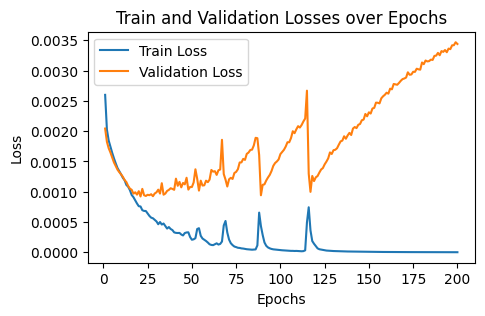

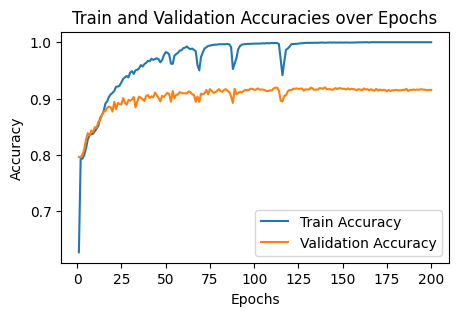

In [29]:
#Loss and accuracy plot
plot_losses(train_losses, valid_losses, config.EPOCH )
plot_accuracies(train_accuracies, valid_accuracies, config.EPOCH )

In [27]:
# 제일 성능이 좋은 모델 불러오기
model.load_state_dict(torch.load("/home/user/Desktop/bsh/absoluteA/model/6000_tcn_best_model.pth"))
Macro_f1, auroc, accuracy, all_labels, all_probabilities = test(model, test_loader)
print(f"Best epoch: {best_epoch_save}")
print(f"macro F1 Score: {Macro_f1}")
print(f"AUROC: {auroc}")
print(f"Accuracy: {accuracy}")

100%|██████████| 6/6 [00:02<00:00,  2.17it/s]

Best epoch: 140
macro F1 Score: 0.8889601051023761
AUROC: 0.9741267821775684
Accuracy: 0.9240422721268163


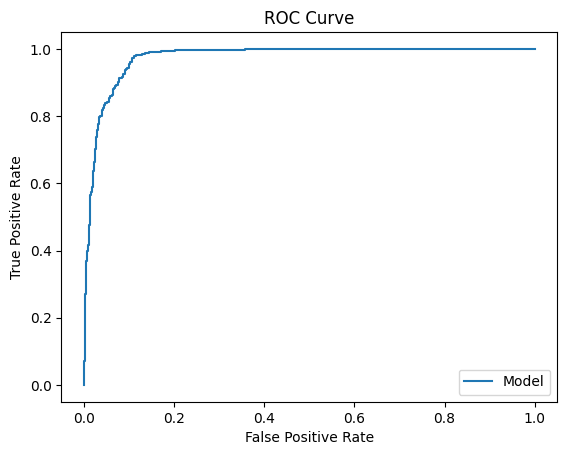

In [31]:
# AUROC plot
plot_roc_curve(all_labels, all_probabilities)